In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

# Add line profiler
%load_ext line_profiler

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import subprocess
import os
import gc
import datetime
import importlib
import logging
from socket import gethostname

import pycuda.driver as cuda
import pycuda.compiler

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
    
#Set large figure sizes
#Note, this prevents nice figures for articles...
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

In [2]:
#Get root logger
logger = logging.getLogger('')
logger.setLevel(logging.DEBUG)

#Add log to file
fh = logging.FileHandler('output.log')
formatter = logging.Formatter('%(asctime)s:%(name)s:%(levelname)s: %(message)s')
fh.setFormatter(formatter)
fh.setLevel(logging.DEBUG)
logger.addHandler(fh)

#Add log to screen
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
logger.addHandler(ch)

In [3]:
from SWESimulators import Common, IPythonMagic

Registering automatic CUDA context handling


In [4]:
%cuda_context_handler cuda_context

CUDA version (9, 1, 0)
Driver version 9010
Using 'GeForce 840M' GPU
Created context handle <482293506944>


In [5]:
#Finally, import our simulator
from SWESimulators import LxF, FORCE, HLL, HLL2, KP07, KP07_dimsplit, WAF

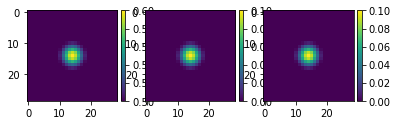

In [6]:
def gen_test_data(nx, ny, g, num_ghost_cells):
    width = 100.0
    height = 100.0
    dx = width / float(nx)
    dy = height / float(ny)

    x_center = dx*nx/2.0
    y_center = dy*ny/2.0

    #Create a gaussian "dam break" that will not form shocks
    size = width / 5.0
    dt = 10**10
    
    h  = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32); 
    hu = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);
    hv = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);
    
    x = dx*(np.arange(-num_ghost_cells, nx+num_ghost_cells, dtype=np.float32)+0.5) - x_center
    y = dy*(np.arange(-num_ghost_cells, ny+num_ghost_cells, dtype=np.float32)+0.5) - y_center
    xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
    r = np.sqrt(xv**2 + yv**2)
    xv = None
    yv = None
    gc.collect()
        
    #Generate highres then downsample
    h = 0.5 + 0.1*0.5*(1.0 + np.cos(np.pi*r/size)) * (r < size)
    hu = 0.1*0.5*(1.0 + np.cos(np.pi*r/size)) * (r < size)
    hv = 0.1*0.5*(1.0 + np.cos(np.pi*r/size)) * (r < size)
    
    scale = 0.7
    max_h_estimate = 0.6
    max_u_estimate = 0.1*np.sqrt(2.0)
    dx = width/nx
    dy = height/ny
    dt = scale * min(dx, dy) / (max_u_estimate + np.sqrt(g*max_h_estimate))
    
    return h, hu, hv, dx, dy, dt

h, hu, hv, dx, dy, dt = gen_test_data(nx=25, ny=25, g=9.81, num_ghost_cells=2)

plt.figure()
ax=plt.subplot(1,3,1)
im=plt.imshow(h)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax=plt.subplot(1,3,2)
im=plt.imshow(hu)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax=plt.subplot(1,3,3)
im=plt.imshow(hv)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()

In [7]:
def sanity_check(variable):
    maxval = np.amax(variable)
    minval = np.amin(variable)
    if (np.isnan(maxval) 
            or np.isnan(minval)
            or maxval > 10.0
            or minval < -10.0):
        return False
    else:
        return True

def run_benchmark(simulator, 
                  h0, hu0, hv0, dx, dy, dt, nx, ny, 
                  block_width, block_height, 
                  g=9.81, timesteps=10):
    logger = logging.getLogger(__name__)
    
    #Initialize simulator
    try:
        sim = simulator(cuda_context, 
                        h0, hu0, hv0, 
                        nx, ny, 
                        dx, dy, dt, 
                        g, 
                        block_width=block_width, block_height=block_height)
    except:
        #An exception raised - not possible to continue
        return np.nan
    
    #Warmup
    for i in range(5):
        sim.stepEuler(dt)
    sim.synchronize()

    #Run simulation with timer
    
    start = cuda.Event()
    end = cuda.Event()
    with Common.Timer(simulator.__name__ + "_" + str(block_width) + "x" + str(block_height)) as timer:
        start.record(sim.stream)
        for i in range(timesteps):
            sim.stepEuler(dt)
        end.record(sim.stream)
        end.synchronize()
    gpu_elapsed = end.time_since(start)*1.0e-3
    megacells = (nx*ny*timesteps / (1000*1000)) / gpu_elapsed
    logger.debug("Megacells %f, gpu elapsed %f, wall elapsed %f", megacells, gpu_elapsed, timer.secs)

    #Sanity check solution
    h, hu, hv = sim.download()
    sane = True
    sane = sane and sanity_check(h)
    sane = sane and sanity_check(hu)
    sane = sane and sanity_check(hv)
    
    if (sane):
        return megacells
    else:
        return np.nan

In [8]:
nx = 2048
ny = 2048
simulators = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, WAF.WAF, KP07.KP07, KP07_dimsplit.KP07_dimsplit]
simulator_ghost_cells = [1, 1, 1, 2, 2, 2, 2]
simulator_courant_numbers = [0.9, 0.9, 0.9, 0.9, 0.9, 0.45, 0.9]
block_widths = range(8, 32, 2)
block_heights = range(8, 32, 2)

filename = "autotuning_data_" + gethostname() + ".npz"

megacells = np.empty((len(simulators), len(block_heights), len(block_widths)))
megacells.fill(np.nan)
for i, simulator in enumerate(simulators):
    #Generate initial conditions
    h0, hu0, hv0, dx, dy, dt = gen_test_data(nx=nx, ny=ny, g=9.81, num_ghost_cells=simulator_ghost_cells[i])
    dt = dt * simulator_courant_numbers[i]

    total_sims = len(block_heights)*len(block_widths)
    with Common.Timer(simulator.__name__) as t:
        for j, block_height in enumerate(block_heights):
            for k, block_width in enumerate(block_widths):
                sims_so_far = j*len(block_widths)+k+1
                sims_remaining = total_sims - sims_so_far
                print('='*(sims_so_far-1), end='')
                print('>', end='')
                print('-'*sims_remaining, end='\r', flush=True)
                megacells[i, j, k] = run_benchmark(simulator, 
                             h0, hu0, hv0, dx, dy, dt, nx, ny, 
                             block_width, block_height)
    print("")
    print("Completed " + simulator.__name__ + " in " + str(t.secs) + " seconds")
    

np.savez_compressed(filename, megacells=megacells)

===============================================================================================================================================>
Completed LxF in 96.28947472572327 seconds
===============================================================================================================================================>
Completed FORCE in 107.3589289188385 seconds
===============================================================================================================================================>
Completed HLL in 130.474853515625 seconds
===============================================================================================================================================>
Completed HLL2 in 185.12253713607788 seconds
===============================================================================================================================================>
Completed WAF in 212.6702971458435 seconds
=========================================================

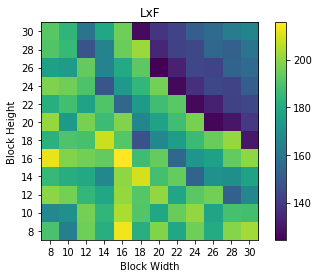

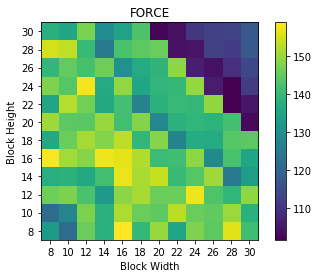

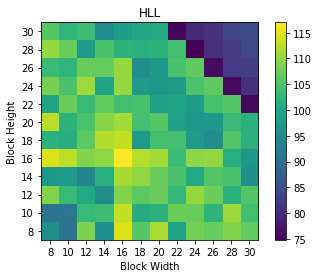

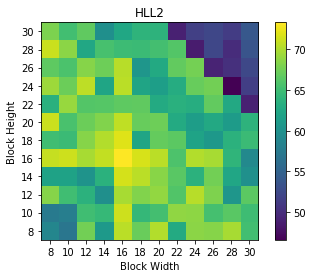

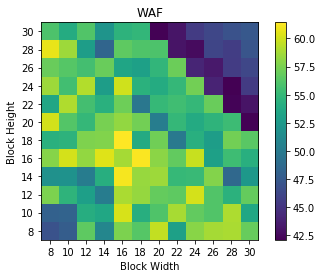

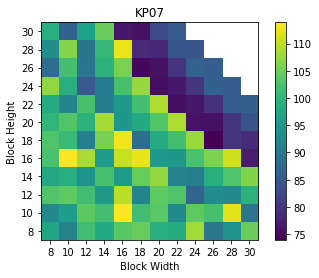

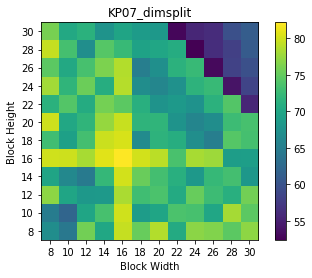

In [10]:
with np.load(filename) as data:
    megacells = data['megacells']

    maximum=np.nanmax(megacells)
    minimum=np.nanmin(megacells)

    for i, simulator in enumerate(simulators):
        plt.figure()
        plt.imshow(megacells[i,:,:], origin='lower')#, vmax=maximum, vmin=minimum)
        plt.xlabel('Block Width')
        plt.xticks(range(len(block_widths)), block_widths)
        plt.ylabel('Block Height')
        plt.yticks(range(len(block_heights)), block_heights)
        plt.colorbar()
        plt.title(simulator.__name__)

LxF
max: 215.62009325357653 (16x16)
min: 124.40000433737893 (26x20)
avg: 175.8778243221413
FORCE
max: 158.8510596685369 (8x16)
min: 101.53257697389986 (22x28)
avg: 137.92428870513444
HLL
max: 117.00954351202085 (16x16)
min: 74.8137282233455 (28x24)
avg: 101.54590369681614
HLL2
max: 73.32764243325421 (16x16)
min: 46.580753309787006 (24x28)
avg: 64.35969060495039
WAF
max: 61.4331160057729 (18x16)
min: 42.10309033399548 (24x28)
avg: 54.046555981587524
KP07
max: 113.90065429727966 (10x16)
min: 73.95281418966437 (18x26)
avg: nan
KP07_dimsplit
max: 82.20246966473113 (16x16)
min: 52.38926982737787 (28x24)
avg: 70.97011662268649


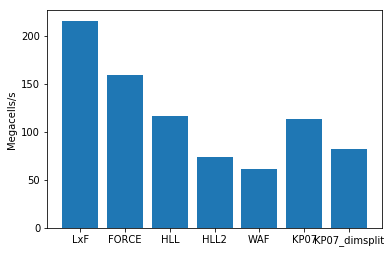

In [22]:
def find_max_index(megacells):
    max_index = np.nanargmax(megacells)
    return np.unravel_index(max_index, megacells.shape)

def find_min_index(megacells):
    min_index = np.nanargmin(megacells)
    return np.unravel_index(min_index, megacells.shape)


with np.load(filename) as data:
    megacells = data['megacells']
    for i, simulator in enumerate(simulators):
        print(simulator.__name__)

        j, k = find_max_index(megacells[i,:,:])
        print("max: {:} ({:}x{:})".format(megacells[i, j, k], block_heights[j], block_widths[k]))

        j, k = find_min_index(megacells[i,:,:])
        print("min: {:} ({:}x{:})".format(megacells[i, j, k], block_heights[j], block_widths[k]))

        print("avg: {:}".format(np.mean(megacells[i,:,:])))
        
    plt.figure()
    plt.bar(range(len(simulators)), np.nanmax(megacells, axis=(1,2)))
    plt.xticks(range(len(simulators)), [simulator.__name__ for simulator in simulators])
    plt.ylabel('Megacells/s')

[215.62009325 158.85105967 117.00954351  73.32764243  61.43311601
 113.9006543   82.20246966]
